In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#auto
#plt.ioff()

##### TODO: select the strongest peaks only

peaks = np.load('cxic0515_peaks23.npy')
iX = np.load('cxic0515_iX.npy')
iY = np.load('cxic0515_iY.npy')

cx = 863 # self.parent.cx
cy = 881 # self.parent.cy

photonEnergy = 12.6889 # keV
D = 0.144 # m
pixSize = 110e-6 # m
wavelength = 12.407002 / float(photonEnergy) * 1e-10  # m

cenX = iX[np.array(peaks[:, 0], dtype=np.int64),
          np.array(peaks[:, 1], dtype=np.int64),
          np.array(peaks[:, 2], dtype=np.int64)] + 0.5 # pixels
cenY = iY[np.array(peaks[:, 0], dtype=np.int64),
          np.array(peaks[:, 1], dtype=np.int64),
          np.array(peaks[:, 2], dtype=np.int64)] + 0.5 # pixels

#strongInd = np.where(cenX > 500) and np.where(cenX < 1100) and np.where(cenY > 500) and np.where(cenY < 1100)
#cenX = cenX[strongInd]
#cenY = cenY[strongInd]

Xd = (cenX - cx) * pixSize # m
Yd = (cenY - cy) * pixSize # m
r = np.sqrt(Xd**2 + Yd**2 + D**2) # m
s = np.array([D/r-1, Xd/r, Yd/r]) / (wavelength) # m^-1

In [2]:
_,numPeaks = s.shape

#norm = np.sqrt(x ** 2 + y ** 2 + z ** 2)
#qPeaks = np.array([x,y,z])/(wavelength*norm)
#s = np.array([D/r-1, Xd/r, Yd/r]) # unitless        

print("s0: ",s[:,0], np.sqrt(np.sum(s[:,0]**2)))
#print(qPeaks)

import matplotlib.pyplot as plt
#plt.plot(y,x,'o')
#plt.plot(0,0,'rx')
#plt.axis('equal')
#plt.show()

#plt.plot(qPeaks[0,:],qPeaks[1,:],'o')
#plt.plot(0,0,'rx')
#plt.axis('equal')
#plt.show()

#from mpl_toolkits.mplot3d import Axes3D
#fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
#ax.scatter(*s)
#ax.set_aspect('equal')
#plt.show()

#ind = 5
#print(np.sqrt(qPeaks[0,ind]**2+qPeaks[1,ind]**2+(qPeaks[2,ind])**2))

# Generate points on hemisphere
N = 200000
dim = 3

np.random.seed(0)
norm = np.random.normal
normal_deviates = norm(size=(dim, N))
print(normal_deviates, normal_deviates.shape)

radius = np.sqrt((normal_deviates**2).sum(axis=0))
points = normal_deviates/radius
ind = np.where(points[0,:]<=0)
points = points[:,ind]
tx = np.squeeze(points[0,:])
ty = np.squeeze(points[1,:])
tz = np.squeeze(points[2,:])
numSamples = len(tx)

#fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
#ax.scatter(*points)
#ax.set_aspect('equal')
#plt.show()

def fj(signal, nBins):
    maxSignal = np.max(signal)
    bins = np.linspace(0, maxSignal, nBins)
    binSize = maxSignal/nBins
    digitized = np.digitize(signal, bins)
    ff = np.zeros((nBins,))
    for i in digitized:
        ff[i-1] += 1
    return ff, bins, binSize

_f = np.zeros((numSamples,numPeaks))
numBins = 2800
f = np.zeros((numSamples,numBins))
F = np.zeros((numSamples,int(numBins/2)))
candidate = []
candidateLen = []
candidateLikely = []
threshF = 50
gap = 5
for j in range(numSamples):
    t = np.array([tx[j], ty[j], tz[j]])
    for i in range(numPeaks):
        q = s[:,i] # Bragg spots in reciprocal space
        p = np.abs(np.dot(q, t)) # Bragg spots projected on to vector t
        _f[j,i] = p 
    f[j,:],bins,binSize = fj(_f[j,:],numBins)   
    sp = np.fft.fftshift(abs(np.fft.fft(f[j,:])))
    F[j,:] = sp[int(numBins/2)::]
    if len(np.where(F[j,gap::]>threshF)[0]):
        candidate.append(j)
        print("candidate: ", j)
        #print("t: ", t)
        #print("q: ", q)
        #print("p: ", p)
        #print("binSize: ", binSize)
        ii = np.where(F[j,gap::]>threshF)[0][0]
        print("pos: ", ii+gap)
        likely = F[j,ii+gap]
        print(likely)
        x_real = (ii+gap) / (numBins * binSize)
        print("unit cell basis vector (real-space dimension): ", x_real)
        candidateLen.append(x_real)
        candidateLikely.append(likely)
        fRange = (numBins * binSize) # m^-1
        FbinSize = 1/fRange # m
        Faxis = range(F.shape[1]) * FbinSize * 1e10 # Angstroms
        #plt.subplot(121)
        #plt.plot(bins,f[j,:])
        #plt.subplot(122)
        #plt.plot(Faxis,F[j,:])
        #plt.xlabel('Axis length (A)')
        #plt.xticks(np.array([0,50,100,150,200]))
        #plt.show()
        #break
print(candidate)

s0:  [-4.05198338e+08 -2.62977509e+09  1.09917846e+09] 2878905350.8465357
[[ 1.76405235  0.40015721  0.97873798 ...  0.66781483 -1.02119452
  -0.34537316]
 [ 0.0395099   0.33837761 -0.84218319 ...  1.23838592 -0.12530564
   0.56857042]
 [-1.05173782  0.13980975 -1.09872236 ...  0.55318153  1.62551497
  -0.32702029]] (3, 200000)
candidate:  106
pos:  25
74.72775097058457
unit cell basis vector (real-space dimension):  5.474898622369807e-09
candidate:  142
pos:  18
61.39973726309288
unit cell basis vector (real-space dimension):  4.90410913321091e-09
candidate:  314
pos:  38
114.9631318163625
unit cell basis vector (real-space dimension):  9.846409231301456e-09
candidate:  416
pos:  19
51.0321395077934
unit cell basis vector (real-space dimension):  5.258036713226429e-09
candidate:  563
pos:  26
96.13408012343368
unit cell basis vector (real-space dimension):  5.843541393708634e-09
candidate:  687
pos:  177
73.17876146310168
unit cell basis vector (real-space dimension):  4.4513670131067

candidate:  7398
pos:  59
87.85387735073282
unit cell basis vector (real-space dimension):  1.3941592594565926e-08
candidate:  7513
pos:  26
66.79851863012654
unit cell basis vector (real-space dimension):  5.8791963418182596e-09
candidate:  7521
pos:  37
51.88174021735704
unit cell basis vector (real-space dimension):  9.411922686643962e-09
candidate:  7601
pos:  25
62.86533552749624
unit cell basis vector (real-space dimension):  5.4545072616127125e-09
candidate:  7641
pos:  27
63.28465872152572
unit cell basis vector (real-space dimension):  1.0768997292090078e-08
candidate:  7666
pos:  42
53.294368735910766
unit cell basis vector (real-space dimension):  1.0914049742474681e-08
candidate:  7983
pos:  24
56.08388367032554
unit cell basis vector (real-space dimension):  5.104592413461526e-09
candidate:  8188
pos:  38
61.141923951717004
unit cell basis vector (real-space dimension):  9.569268737932307e-09
candidate:  8205
pos:  44
69.66690429565597
unit cell basis vector (real-space di

candidate:  14678
pos:  25
53.52869402060758
unit cell basis vector (real-space dimension):  5.336081867031285e-09
candidate:  14703
pos:  26
62.778799251858246
unit cell basis vector (real-space dimension):  5.937578723383706e-09
candidate:  14708
pos:  26
51.133663668841486
unit cell basis vector (real-space dimension):  5.679985351263178e-09
candidate:  14731
pos:  73
78.76119778273551
unit cell basis vector (real-space dimension):  2.0620255157266967e-08
candidate:  14824
pos:  88
58.47273191672128
unit cell basis vector (real-space dimension):  1.8212100068544527e-08
candidate:  14876
pos:  25
69.2107549543585
unit cell basis vector (real-space dimension):  5.530867999292192e-09
candidate:  15000
pos:  25
53.146965234470166
unit cell basis vector (real-space dimension):  5.465638934720024e-09
candidate:  15078
pos:  122
69.3385764924772
unit cell basis vector (real-space dimension):  2.998631770109555e-08
candidate:  15102
pos:  49
77.27415295813435
unit cell basis vector (real-sp

candidate:  22376
pos:  26
52.86560255393683
unit cell basis vector (real-space dimension):  5.657535418336207e-09
candidate:  22476
pos:  38
106.44577749303377
unit cell basis vector (real-space dimension):  9.942407577763655e-09
candidate:  22483
pos:  25
59.36558141264937
unit cell basis vector (real-space dimension):  5.562923877716294e-09
candidate:  22609
pos:  25
57.906406220899484
unit cell basis vector (real-space dimension):  5.5066757050991194e-09
candidate:  22624
pos:  26
56.34248607958157
unit cell basis vector (real-space dimension):  5.96495658696805e-09
candidate:  22641
pos:  67
58.5273574348064
unit cell basis vector (real-space dimension):  1.4489634120121478e-08
candidate:  22975
pos:  46
52.9192203960613
unit cell basis vector (real-space dimension):  1.1154590435804129e-08
candidate:  22990
pos:  72
64.10071113634378
unit cell basis vector (real-space dimension):  1.530183591153089e-08
candidate:  23239
pos:  25
85.22635961225328
unit cell basis vector (real-spac

candidate:  30008
pos:  127
53.274089811973475
unit cell basis vector (real-space dimension):  3.0035538403615914e-08
candidate:  30262
pos:  26
84.82750762469381
unit cell basis vector (real-space dimension):  5.799948206103181e-09
candidate:  30365
pos:  25
69.22401205393366
unit cell basis vector (real-space dimension):  5.4963970556845656e-09
candidate:  30401
pos:  131
53.749938126161574
unit cell basis vector (real-space dimension):  3.3127183379090295e-08
candidate:  30414
pos:  102
50.849349011100394
unit cell basis vector (real-space dimension):  2.5459324927615622e-08
candidate:  30462
pos:  72
76.26781572979664
unit cell basis vector (real-space dimension):  1.529771451196911e-08
candidate:  30552
pos:  18
80.94068702049145
unit cell basis vector (real-space dimension):  4.939992239502021e-09
candidate:  30622
pos:  143
72.06727609620546
unit cell basis vector (real-space dimension):  4.2724368963117454e-08
candidate:  30832
pos:  100
51.97781496772726
unit cell basis vector

candidate:  39293
pos:  65
94.32646904493924
unit cell basis vector (real-space dimension):  1.5174287833828722e-08
candidate:  39415
pos:  26
95.75851139753522
unit cell basis vector (real-space dimension):  5.7634232852189055e-09
candidate:  39726
pos:  43
50.01405634203063
unit cell basis vector (real-space dimension):  1.135213573266992e-08
candidate:  40101
pos:  102
51.895805649570356
unit cell basis vector (real-space dimension):  2.517835382915105e-08
candidate:  40114
pos:  77
52.45204553762212
unit cell basis vector (real-space dimension):  2.0153501794457307e-08
candidate:  40210
pos:  109
59.20935386830556
unit cell basis vector (real-space dimension):  2.572117339798496e-08
candidate:  40213
pos:  26
61.23753186122669
unit cell basis vector (real-space dimension):  5.899984971572052e-09
candidate:  40233
pos:  44
50.13507620109382
unit cell basis vector (real-space dimension):  1.1452496827273425e-08
candidate:  40251
pos:  25
70.40551231960886
unit cell basis vector (real

candidate:  46842
pos:  24
52.22513386527565
unit cell basis vector (real-space dimension):  5.099350809335957e-09
candidate:  47024
pos:  108
70.67298693168942
unit cell basis vector (real-space dimension):  3.1808333738808844e-08
candidate:  47079
pos:  38
57.873144893990414
unit cell basis vector (real-space dimension):  9.645443320943024e-09
candidate:  47127
pos:  18
66.21506321713757
unit cell basis vector (real-space dimension):  4.9174950075680716e-09
candidate:  47170
pos:  24
55.07152719296983
unit cell basis vector (real-space dimension):  5.100553492300542e-09
candidate:  47306
pos:  25
79.11726735388488
unit cell basis vector (real-space dimension):  5.337405250393873e-09
candidate:  47458
pos:  38
61.40293725538317
unit cell basis vector (real-space dimension):  1.1753820300086152e-08
candidate:  47681
pos:  35
59.07731450157807
unit cell basis vector (real-space dimension):  9.433783927565532e-09
candidate:  47777
pos:  108
65.28937923785662
unit cell basis vector (real-

candidate:  55736
pos:  26
63.70414113987695
unit cell basis vector (real-space dimension):  5.870335252873125e-09
candidate:  55791
pos:  95
55.66991499329256
unit cell basis vector (real-space dimension):  2.155304854476935e-08
candidate:  56016
pos:  151
50.9882451008157
unit cell basis vector (real-space dimension):  3.488842428496274e-08
candidate:  56078
pos:  110
64.33992791675452
unit cell basis vector (real-space dimension):  2.6073988347722753e-08
candidate:  56116
pos:  44
56.77094502718246
unit cell basis vector (real-space dimension):  1.1194963237945476e-08
candidate:  56200
pos:  37
69.39443462620935
unit cell basis vector (real-space dimension):  8.645900162205606e-09
candidate:  56226
pos:  26
52.676243454816515
unit cell basis vector (real-space dimension):  5.625173576044915e-09
candidate:  56275
pos:  177
78.4755714695363
unit cell basis vector (real-space dimension):  4.4375448538440755e-08
candidate:  56321
pos:  44
55.633110060688836
unit cell basis vector (real-

candidate:  64364
pos:  25
66.5234815562253
unit cell basis vector (real-space dimension):  5.489361813898027e-09
candidate:  64398
pos:  26
98.14125063890985
unit cell basis vector (real-space dimension):  5.782759786047111e-09
candidate:  64674
pos:  46
73.90303876195041
unit cell basis vector (real-space dimension):  9.908847789664033e-09
candidate:  64692
pos:  38
117.34793336752536
unit cell basis vector (real-space dimension):  9.893796432954312e-09
candidate:  64768
pos:  25
63.47883640011067
unit cell basis vector (real-space dimension):  5.348849430164751e-09
candidate:  64810
pos:  24
54.76917820378992
unit cell basis vector (real-space dimension):  5.109407372613582e-09
candidate:  65438
pos:  18
75.65538479231753
unit cell basis vector (real-space dimension):  4.923692436637361e-09
candidate:  65576
pos:  46
53.9278056165517
unit cell basis vector (real-space dimension):  9.880265185354077e-09
candidate:  65768
pos:  18
51.826809385444285
unit cell basis vector (real-space 

candidate:  72678
pos:  25
71.03047206641382
unit cell basis vector (real-space dimension):  5.336750300911844e-09
candidate:  73122
pos:  38
53.81434723875595
unit cell basis vector (real-space dimension):  1.0033474870869039e-08
candidate:  73226
pos:  24
56.322162996506066
unit cell basis vector (real-space dimension):  5.107643242875469e-09
candidate:  73251
pos:  34
50.73897089529897
unit cell basis vector (real-space dimension):  9.067790278743035e-09
candidate:  73252
pos:  24
56.81771882024683
unit cell basis vector (real-space dimension):  5.106975392704811e-09
candidate:  73258
pos:  62
63.332419384137104
unit cell basis vector (real-space dimension):  2.1497896243042375e-08
candidate:  73327
pos:  25
66.81811570899794
unit cell basis vector (real-space dimension):  5.495261703799839e-09
candidate:  73440
pos:  78
54.008502203918276
unit cell basis vector (real-space dimension):  1.7865940232590463e-08
candidate:  73819
pos:  58
53.1397696843503
unit cell basis vector (real-s

candidate:  82856
pos:  38
69.46715456438635
unit cell basis vector (real-space dimension):  1.105421022335492e-08
candidate:  83227
pos:  53
51.59847097493337
unit cell basis vector (real-space dimension):  1.4364038781688937e-08
candidate:  83329
pos:  26
56.89315505099648
unit cell basis vector (real-space dimension):  5.960505959416507e-09
candidate:  83373
pos:  90
54.05767066854958
unit cell basis vector (real-space dimension):  2.1899315936683785e-08
candidate:  83399
pos:  106
56.58512200915898
unit cell basis vector (real-space dimension):  2.995214235658686e-08
candidate:  83789
pos:  38
62.29108220355819
unit cell basis vector (real-space dimension):  9.592324699227873e-09
candidate:  83811
pos:  18
58.937764786534245
unit cell basis vector (real-space dimension):  4.888385308745408e-09
candidate:  83828
pos:  38
50.41447317905429
unit cell basis vector (real-space dimension):  9.519763004011084e-09
candidate:  84303
pos:  44
65.52624793201646
unit cell basis vector (real-sp

candidate:  91191
pos:  119
57.116212178462305
unit cell basis vector (real-space dimension):  3.3032507967317324e-08
candidate:  91246
pos:  38
51.198188574271775
unit cell basis vector (real-space dimension):  9.550058495191693e-09
candidate:  91498
pos:  24
57.32236220251956
unit cell basis vector (real-space dimension):  5.103332993527528e-09
candidate:  91529
pos:  18
93.5528675333964
unit cell basis vector (real-space dimension):  5.010962092082777e-09
candidate:  91588
pos:  25
58.94753568126304
unit cell basis vector (real-space dimension):  5.346046577361398e-09
candidate:  91691
pos:  76
77.00505767377157
unit cell basis vector (real-space dimension):  1.9397833536652066e-08
candidate:  91692
pos:  27
54.250514671675234
unit cell basis vector (real-space dimension):  1.1120861486789859e-08
candidate:  91705
pos:  25
74.43345268305426
unit cell basis vector (real-space dimension):  5.476661189775693e-09
candidate:  91799
pos:  26
51.48000475276199
unit cell basis vector (real-

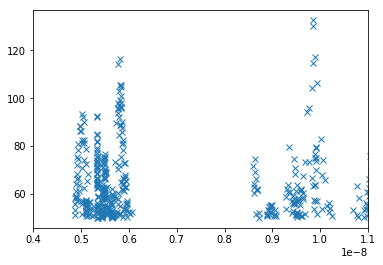

In [3]:
plt.plot(candidateLen,candidateLikely,'x')
plt.xlim([40e-10,110e-10])
plt.show()